In [1]:
import pandas as pd, numpy as np
import os, re, sys
import seaborn as sns

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'MS Gothic'

In [3]:
import gc

In [4]:
import folium
from folium.plugins import HeatMap

In [5]:
from plotly import express as px

---

In [ ]:
df.columns = range(1, df.shape[1]+1)
df = df.loc[:,:1307]
# df.reset_index(drop=True, inplace=True)

In [39]:
def concat_string(sr):
    res = ""
    for x in sr.values:
        if x==x: res += x
    return res

In [40]:
df['NO_CAPCALC'] = df.loc[:, [1011, 1012, 1013]].apply(concat_string, axis=1)
df['NO_CAPAPPLY'] = df.loc[:, [1014, 1015, 1016]].apply(concat_string, axis=1)
df['CALC_DEV'] = df.loc[:, [1018]].apply(concat_string, axis=1)

In [41]:
df['DR_LAND'] = df[1007]
df['CAP_LAND'] = df[1009]

In [42]:
df['PLAND_ROAD'] = df[24]

In [43]:
df['PLAND_COMP'] = df[124]
df['PLAND_CAP'] = df[125]

In [44]:
df['CAP'] = np.where(df[1002] > 0, df[1002] * df[1005] / (df.PLAND_COMP * df[30] + df[1206]) * 100, None)

In [45]:
df['GFATSB_CAP'] = df[1032] / 0.3025
df['RENTABLE_CAP'] = df[1112]
df['TSBVALK_CAP'] = np.where(df.RENTABLE_CAP > 0,
                    (df.PLAND_COMP * df[30] + df[1206]) / df.RENTABLE_CAP / 0.3025 / 1e3, None)
df['COMP2CAP'] = np.where(df.PLAND_CAP > 0, df.PLAND_COMP / df.PLAND_CAP, None)
df['CSFTSB_CAP'] = df[1117] / 0.3025
df['TSBCOSTK_CAP'] = df[1204] * (1 + df[1205]/100) / 0.3025 / 1e3

In [46]:
df['ROIC_DEV'] = df[1021]
df['TSBPRICEK_DEV'] = df[1022] / 0.3025 / 1e3
df['TSBCOSTK_DEV'] = df[1024] / 0.3025 / 1e3
df['NFLR_DEV'] = df[1228]
df['NROOM_DEV'] = df[1230]
df['STDAREA_DEV'] = df[1231]

In [47]:
def concat_id(sr):
    ken, siku, youto, renban = sr.values
    return f"{ken:0>2}{siku:0>3}", f"{ken:0>2}{siku:0>3}{youto:0>3}{renban:0>3}"

In [48]:
df['CITY'], df['ID'] = list(zip(*df.loc[:, [2, 3, 5, 6]].apply(concat_id, axis=1)))
df['ADRS'] = df[28].mask(lambda x:x.isnull(), df[27])
df['BEST_USE'] = df[102]
df['TYPE_CAP'] = df[1027]

In [49]:
col_use = [1043, 1057, 1071, 1085, 1099]

In [50]:
np.unique([re.sub(r"[\s　等]", "", re.split("(?:兼|・|、|及び|乃至)", s)[0]) for s in df[col_use].stack().reset_index(drop=True).values])

array(['', 'その他', 'エントランス', 'エントランスほか', 'ショールーム', 'タワー式駐車場', 'ピット式駐車場',
       'ペントハウス', 'ホテル', 'ロビー', '事務所', '事務所ほか', '事務所付倉庫', '事務所付工場',
       '事務所倉庫', '事務所（育成用途）', '事業所', '住宅', '住宅（アパート）', '住宅（ファミリー）',
       '住宅（ワンルーム）', '住宅（玄関）', '住居', '住居（Ｆ）', '住居（Ｆ／Ｏ）', '住戸', '作業場',
       '作業所', '作業所事務所', '倉庫', '倉庫事務所', '倉庫作業所', '共同住宅', '共用部', '共用部分',
       '内部共用', '受水槽', '営業所', '地下１．２階店舗', '塔屋', '宅宅', '専用住宅', '居宅',
       '屋内駐車場', '屋内駐輪場', '工場', '工場居宅', '帰宅困難者対応施設', '店舗', '店舗ほか', '店舗事務所',
       '店舗他', '店舗併用住宅', '店舗（塔屋部分含む）', '店舗（Ｂ３機械室を含む）', '店舗（Ｂ３機械室込み）',
       '店舗，立体駐車場', '戸建住宅', '搭屋', '機械', '機械室', '機械室駐車場', '機械式駐車場',
       '物流センター', '研究所', '立体駐車場', '荷捌き駐車場', '設備', '車庫', '長屋', '長屋住宅',
       '階段室', '電気機械室', '電気設備室', '飲食店舗', '駐車場', '駐車場ほか', '駐車場エントランス',
       '駐車場他', '駐車場外', '駐車場（別途荷捌きあり）', '駐車場（塔屋含む）', '駐車場（平面）', '駐輪場',
       '駐輪場外', 'ＰＨ'], dtype='<U12')

In [51]:
def getFloorType(s):
    d_type = {
        r"(?:工場|研究所)":"INDU",
        r"(?:倉庫|物流センター)":"LOGI",
        r"(?:住宅|居宅|住居|住戸|[１２３４]Ｌ?ＤＫ|長屋)":"RESI",
        r"(?:事務所|事業所|営業所)":"OFFICE", 
        r"(?:店舗)":"RETAIL",
        r"(?:ホテル)":"HOTEL"}
    for k,v in d_type.items():
        if re.search(k, re.sub(r"[\s　]", "", s)):
            return v
    return "OTHER"

In [52]:
t_floortype = df[col_use].mask(df[col_use].notnull(), df[col_use].fillna("").applymap(lambda x: getFloorType(x)))

In [53]:
t_floorrent = df[[c + 6 for c in col_use]]
t_floorarea = df[[c + 4 for c in col_use]]
t_floorbase = df[[c - 3 for c in col_use]].fillna("").applymap(lambda x: True if x.find("地下") > -1 else False)
t_floorwhole = df[[c - 3 for c in col_use]].fillna("").applymap(lambda x: True if x.find("一括") > -1 else False)
t_floorfrom = df[[c - 2 for c in col_use]]
t_floorto = df[[c - 1 for c in col_use]]
t_floornum = np.abs(t_floorto.values - t_floorfrom.values) + 1

In [41]:
if False:
    i=130019
    display(df.iloc[[i]].loc[:,1027:1043])
    display(df.iloc[[i]].loc[:,1040:1053])
    display(df.iloc[[i]].loc[:,1054:1067])
    display(df.iloc[[i]].loc[:,1068:1081])
    display(df.iloc[[i]].loc[:,1082:1095])
    display(df.iloc[[i]].loc[:,1096:1109])
    display(t_floorbase.iloc[[i]])
    display(t_floorfrom.iloc[[i]])

In [54]:
def estMajorType(t_type, t_rent, t_area, t_num, t_boolbase, t_boolwhole, t_flrfrom, t_flrto):
    if sum(t_rent > 0) == 0:
        return [None] * 3
    x = (pd.DataFrame({
            "TYPE":t_type,
            "RENT":t_rent * t_num,
            "AREA":t_area * t_num})
         .dropna().groupby("TYPE").apply(lambda x:
            pd.Series({"RENT":x.RENT.sum(), "AREA":x.AREA.sum()})).sort_values("RENT"))
    if len(x) == 0:
        return [None] * 3
    if (len(x) > 1) and (x.RENT.iat[-1] == x.RENT.iat[-2]) and (x.index[-2] == "OFFICE"):
        return (x.index[-2], x.RENT.iat[-2] / x.AREA.iat[-2] / 0.3025, None)
    if x.index[-1] == "RETAIL":
        i_1F = np.where((~t_boolbase & ((t_flrfrom == 1) | (t_flrto == 1))) | t_boolwhole)[0][0]
        rent_1F = t_rent[i_1F] / t_area[i_1F] / 0.3025 if t_area[i_1F] > 0 else None
        return ("RETAIL", x.RENT.iat[-1] / x.AREA.iat[-1] / 0.3025, rent_1F)
    return (x.index[-1], x.RENT.iat[-1] / x.AREA.iat[-1] / 0.3025, None)

In [55]:
l_type = []; l_rent = []; l_rent1F = []
for i in range(len(t_floorrent)):
    sys.stdout.write(f"\r{i+1:>5}/{len(t_floorrent)}"); sys.stdout.flush()
    major_type, major_rent, rent_1F = estMajorType(
        t_floortype.iloc[i].values, t_floorrent.iloc[i].values,
        t_floorarea.iloc[i].values, t_floornum[i], 
        t_floorbase.iloc[i].values, t_floorwhole.iloc[i].values,
        t_floorfrom.iloc[i].values, t_floorto.iloc[i].values)
    l_type.append(major_type)
    l_rent.append(major_rent)
    l_rent1F.append(rent_1F)
print("\ndone.")

51742/51742
done.


In [56]:
df['TYPEMAJOR_CAP'] = l_type
df['RENTTSB_CAP'] = l_rent
df['RENT1F_CAP'] = l_rent1F
df.RENTTSB_CAP += df.CSFTSB_CAP
df.RENT1F_CAP += df.CSFTSB_CAP

In [57]:
df.loc[
    (df.TYPEMAJOR_CAP=="RESI") & df.TYPE_CAP.fillna("").str.contains(r"戸建"),
    "TYPEMAJOR_CAP"] = "SGLFAMILY"

In [407]:
koji = 

In [408]:
koji['CODE'] = koji[["所在地コード", "用途", "連番"]].apply(lambda x:f"{x[0]:>05d}{x[1]:>03d}{x[2]:>03d}", axis=1)

In [409]:
koji = koji[koji["用途"].isin([0, 5, 9])]

In [410]:
koji['LON'] = koji['経度'] / 3600.
koji['LAT'] = koji['緯度'] / 3600.

In [519]:
df = 

In [412]:
def concat_preid(sr):
    ken, siku, youto, renban = sr.values
    if pd.isnull(ken): return None
    return f"{int(ken):0>2}{int(siku):0>3}{int(youto):0>3}{int(renban):0>3}"

In [413]:
df['PREID'] = df[[7, 8, 10, 11]].apply(concat_preid, axis=1)

In [414]:
d_preid_id = {}
for y in range(2020, 2023):
    d_preid_id[y] = dict(df[(df[1]==y) & df.PREID.notnull()][["PREID", "ID"]].values)

In [415]:
for y in range(2019, 2022):
    for _y in range(y+1, 2023):
        df.loc[df[1] == y, "ID"] = np.where(df.loc[df[1] == y].ID.isin(d_preid_id[_y].keys()), df.loc[df[1] == y].ID.map(d_preid_id[_y]), None)

In [416]:
df = df[df.ID.notnull()]

In [417]:
df['YEAR'] = df[1]
df = df[["YEAR", "ID", 'CITY', 'ADRS', 'BEST_USE', "TYPE_CAP", "DR_LAND", "CAP_LAND",
         "PLAND_COMP", "PLAND_CAP", "PLAND_ROAD",
         "CAP", "TSBVALK_CAP", "TYPEMAJOR_CAP", "RENTTSB_CAP", "RENT1F_CAP", "TSBCOSTK_CAP", "GFATSB_CAP", "COMP2CAP",
         "ROIC_DEV", "TSBPRICEK_DEV", "TSBCOSTK_DEV", "NFLR_DEV", "NROOM_DEV", "STDAREA_DEV"]]

In [418]:
gc.collect()

27510

In [419]:
def addNo(df):
    df = df.sort_values("ID")

    x = np.where(df.ID == df.ID.shift(1), 1, 0)
    for i in range(len(x)):
        if x[i] > 0:
            x[i] = x[i-1] + 1
    df["NO"] = x
    
    return df

In [420]:
df = df.groupby("YEAR").apply(addNo).reset_index(drop=True)

In [421]:
df = df.set_index(['YEAR', 'ID', 'NO']).unstack("NO")

In [422]:
df.columns = [f"{a}{b+1}" for a,b in df.columns]

In [423]:
for s in ['CITY', 'ADRS']:
    df.drop(f"{s}2", axis=1, inplace=True)
    df.rename(columns={f"{s}1":f"{s}"}, inplace=True)

In [424]:
for s in [ss[:-1] for ss in df.columns if re.search(r"1$", ss)]:
    if s in ["TYPE_CAP", "TYPEMAJOR_CAP", "BEST_USE"]: continue
    df.loc[:, [f"{s}1", f"{s}2"]] = df[[f"{s}1", f"{s}2"]].where(lambda x: x > 0, None)
    df[s] = np.where(
        df.TYPEMAJOR_CAP1.fillna("") != df.TYPEMAJOR_CAP2.fillna(""), # 主要用途が一致しない場合は賃料単価高い方を採用
        np.where(df.RENTTSB_CAP1 >= df.RENTTSB_CAP2, df[f"{s}1"], df[f"{s}2"]),
        df[[f"{s}1", f"{s}2"]].mean(axis=1))

In [425]:
df['BEST_USE'] = df.BEST_USE1 + "／" + df.BEST_USE2

In [426]:
df['TYPE_CAP'] = np.where(df.TYPE_CAP1.notnull(), df.TYPE_CAP1 + "／" + df.TYPE_CAP2, None)

In [427]:
df['TYPEMAJOR_CAP'] = np.where(
    df.TYPEMAJOR_CAP1.fillna("") != df.TYPEMAJOR_CAP2.fillna(""),
    np.where(df.RENTTSB_CAP1 >= df.RENTTSB_CAP2, df.TYPEMAJOR_CAP1, df.TYPEMAJOR_CAP2),
    df.TYPEMAJOR_CAP1)

In [428]:
df['COMP2CAP'] = df.PLAND_COMP / df.PLAND_CAP

In [429]:
df = df[[s for s in df.columns if not re.search(r"[12]$", s)]]

In [430]:
df = df.unstack("YEAR")

In [431]:
df.columns = [f"{a}{b%100}" for a,b in df.columns]

In [432]:
for s in ['CITY', 'ADRS']:
    for y in range(19, 22):
        df.drop(f"{s}{y}", axis=1, inplace=True)
    df.rename(columns={f"{s}22":f"{s}"}, inplace=True)

In [434]:
df = df.reset_index().merge(
        koji[["LAT", "LON", "用途", "Ｒ４価格", "CODE", '所在並びに地番']], left_on='ID', right_on='CODE', how='inner')

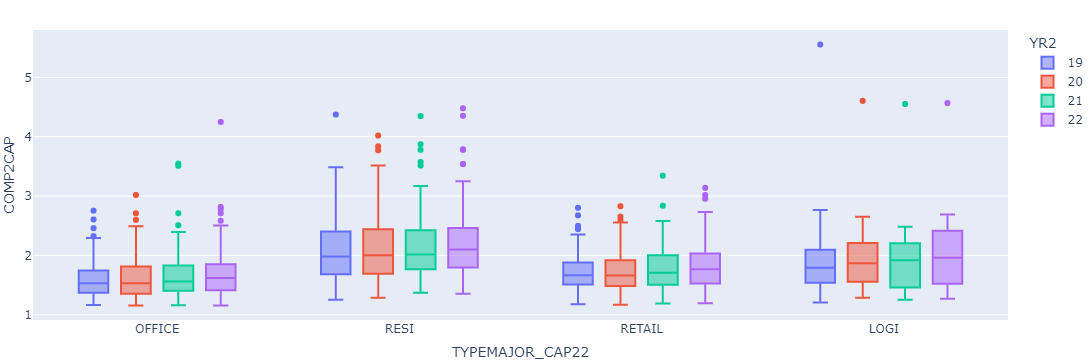

In [393]:
fig = (df
 .query("COMP2CAP22.notnull()", engine='python')
 .assign(CITY2 = lambda x:x.CITY.str.replace('[0-9]{3}$', '', regex=True))
 .query("TYPEMAJOR_CAP22 in ('OFFICE', 'RESI', 'RETAIL', 'LOGI')")
 .groupby(["CITY2", "TYPEMAJOR_CAP22"]).apply(lambda x:x[['COMP2CAP19', 'COMP2CAP20', 'COMP2CAP21', 'COMP2CAP22']].median(axis=0))
 .reset_index()
 .melt(id_vars=['CITY2', 'TYPEMAJOR_CAP22'], value_vars=['COMP2CAP19', 'COMP2CAP20', 'COMP2CAP21', 'COMP2CAP22'], var_name='YR', value_name='COMP2CAP')
 .assign(YR2 = lambda x:x.YR.str.extract(r"([0-9]+)$"))
 .pipe(lambda df:px.box(df, x='TYPEMAJOR_CAP22', y='COMP2CAP', color='YR2', hover_data=['CITY2'],
                        category_orders=dict(TYPEMAJOR_CAP22=['OFFICE', 'RESI', 'RETAIL', 'LOGI'])))
)
fig.update_layout(margin=dict(l=0,r=0,t=30,b=0))
fig.show()

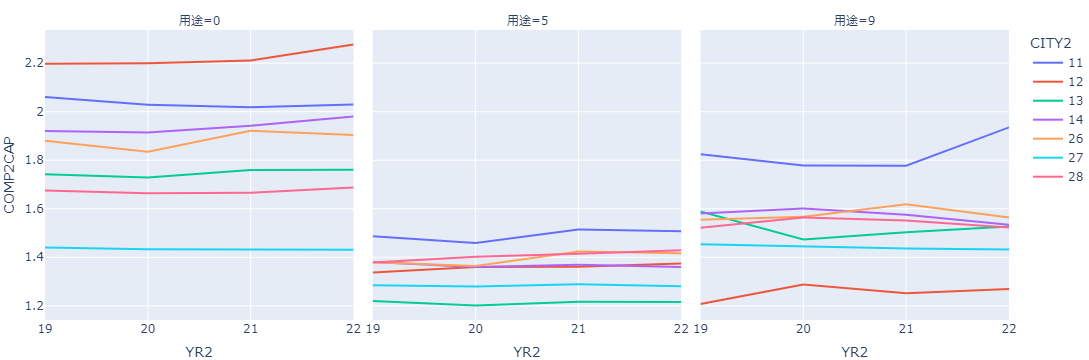

In [495]:
fig = (df
 .query("COMP2CAP22.notnull()", engine='python')
#  .query("用途 in (0, 5)")
 .assign(CITY2 = lambda x:x.CITY.str.replace('[0-9]{3}$', '', regex=True))
#  .groupby(["CITY2", "TYPEMAJOR_CAP22"]).apply(lambda x:x[['COMP2CAP19', 'COMP2CAP20', 'COMP2CAP21', 'COMP2CAP22']].median(axis=0))
#  .xs('RESI', level='TYPEMAJOR_CAP22', axis=0)
 .groupby(["CITY2", '用途']).apply(lambda x:x[['COMP2CAP19', 'COMP2CAP20', 'COMP2CAP21', 'COMP2CAP22']].median(axis=0))
 .reset_index()
 .melt(id_vars=['CITY2', '用途'], value_vars=['COMP2CAP19', 'COMP2CAP20', 'COMP2CAP21', 'COMP2CAP22'], var_name='YR', value_name='COMP2CAP')
 .query("CITY2 in ('11', '12', '13', '14', '26', '27', '28')")
 .assign(YR2 = lambda x:x.YR.str.extract(r"([0-9]+)$"))
 .pipe(lambda df: px.line(df, x='YR2', y='COMP2CAP', color='CITY2', facet_col='用途', width=900, height=350))
)
fig.update_layout(margin=dict(l=0,r=0,t=30,b=0))
fig.show()

- 商業地は収益性に基づく価格で取引されている傾向が強く、住宅地は賃貸事業の収益性を大きく上回る価格で取引されている傾向
- 商業地の中でも、東京、大阪の取引価格はファンダメンタルズから乖離しにくいと言える。コロナ禍前後でほぼ変化みられない
- 住宅地の中では、取引価格が収益性を強く反映しているのは大阪、次いで兵庫、東京、京都
  - 関西の方が関東よりも、住宅地の取引において収益性が考慮された価格付けになっていると解釈
  - 千葉県の住宅地は、比準価格が取引価格を大きく上回り、かつ2022年にかけて乖離が広がっている
 

In [401]:
from folium import CircleMarker

In [542]:
#空白地図の作成
center = [35.67083, 139.74375]
m = folium.Map(center, zoom_start = 10, width=600, height=400)#, tiles='Stamen Toner')

yxwi = (df
 .query("用途 == 5")
 .pipe(lambda x:x[x.CITY.apply(lambda s:s[:2])=="13"])
 [["LAT", "LON", "COMP2CAP22", "ID"]].values)

for y, x, w, i in yxwi:
    c = matplotlib.colors.rgb2hex(plt.cm.RdYlBu(min(w/3., 1.0))) # (0, 3)
    CircleMarker(location=(y, x), radius=3, color=c, popup=i, fill=True, fill_color=c).add_to(m)

from branca.element import Figure
fig = Figure(width=600, height=400)
fig.add_child(m)

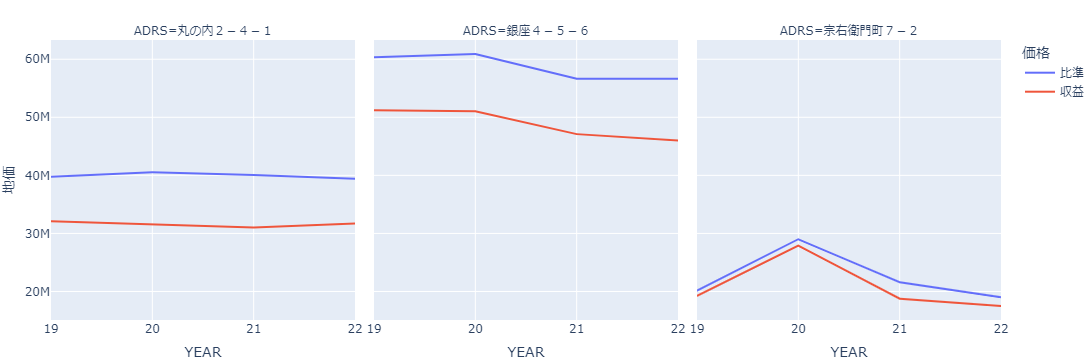

In [511]:
s_ids = [
    '13101005002', # 丸ビル
    '13102005022', # 山野楽器
    '27128005002', # 心斎橋
]

fig = px.line(
    df[df.ID.isin(s_ids)].set_index("ID")[[
        'PLAND_COMP19', 'PLAND_COMP20', 'PLAND_COMP21', 'PLAND_COMP22',
        'PLAND_CAP19', 'PLAND_CAP20', 'PLAND_CAP21', 'PLAND_CAP22']].T
    .stack().reset_index("ID")
    .pipe(
        lambda x: pd.DataFrame(
            np.concatenate([x.values, x.index.str.extract(r"^PLAND_([^0-9]+)([0-9]+)$").values], axis=1),
            columns=['ID', 'PLAND', 'DATA', 'YR']))
    .assign(ADRS=lambda x:x.ID.map(dict(df[["ID", "ADRS"]].values)))
    .assign(DATAJ=lambda x:x.DATA.map({'COMP':'比準', 'CAP':'収益'})),
    x='YR', y='PLAND', color='DATAJ', facet_col='ADRS', 
    labels={'YR':'YEAR', 'PLAND':'地価', 'DATAJ':'価格'},
    width=900, height=350)
fig.update_layout(margin=dict(l=0,r=0,t=40,b=0))
fig.show()

- 丸ビル：2022は比準価格が若干低下の一方、収益価格は若干上昇（還元利回りの低下が主因とみられる）。乖離は縮小。
- 銀座：コロナ禍拡大後の2021年に比準価格も収益価格も低下。収益価格は2022年も若干低下し、乖離が若干拡大
- 心斎橋：2020年に比準価格が大幅上昇したが、収益価格も上昇しており、ファンダメンタルズの改善を反映した取引価格の上昇と捉えられる。バブルとは言えない
  - 比準価格は2021年から低下したが、収益価格も同様に低下しており、この時もインバウンド消費の落ち込みなどファンダメンタルズを反映した動き。

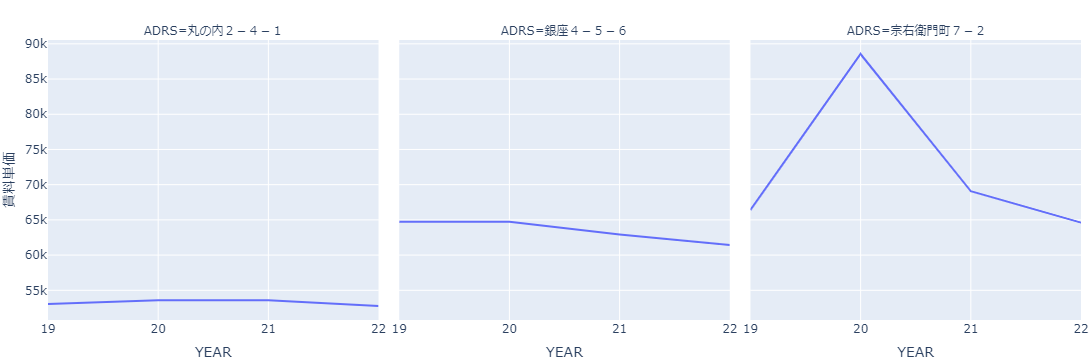

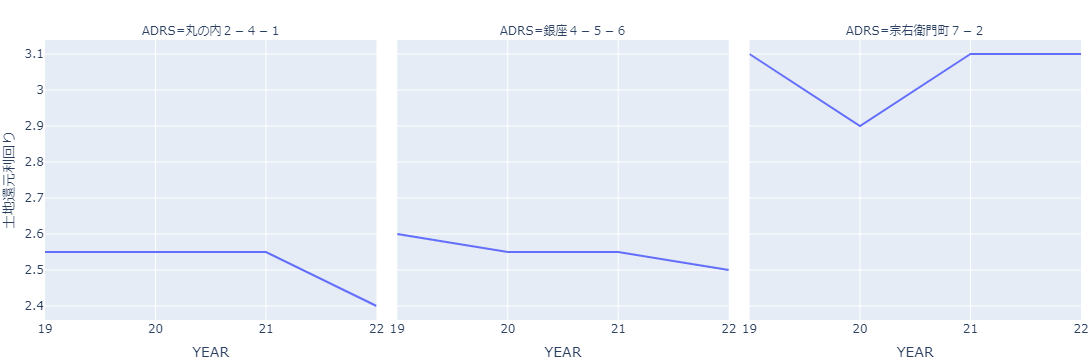

In [517]:
s_ids = [
    '13101005002', # 丸ビル
    '13102005022', # 山野楽器
    '27128005002', # 心斎橋
]

fig = px.line(
    df[df.ID.isin(s_ids)].set_index("ID")[[
        'RENTTSB_CAP19', 'RENTTSB_CAP20', 'RENTTSB_CAP21', 'RENTTSB_CAP22']].T
    .stack().reset_index("ID")
    .pipe(
        lambda x: pd.DataFrame(
            np.concatenate([x.values, x.index.str.extract(r"^([^_]+)_[^0-9]+([0-9]+)$").values], axis=1),
            columns=['ID', 'VALUE', 'DATA', 'YR']))
    .assign(ADRS=lambda x:x.ID.map(dict(df[["ID", "ADRS"]].values))),
    x='YR', y='VALUE', facet_col='ADRS', 
    labels={'YR':'YEAR', 'VALUE':'賃料単価'},
    width=900, height=350)
fig.update_layout(margin=dict(l=0,r=0,t=40,b=0))
fig.show()



fig = px.line(
    df[df.ID.isin(s_ids)].set_index("ID")[[
        'CAP_LAND19', 'CAP_LAND20', 'CAP_LAND21', 'CAP_LAND22']].T
    .stack().reset_index("ID")
    .pipe(
        lambda x: pd.DataFrame(
            np.concatenate([x.values, x.index.str.extract(r"^([^_]+)_[^0-9]+([0-9]+)$").values], axis=1),
            columns=['ID', 'VALUE', 'DATA', 'YR']))
    .assign(ADRS=lambda x:x.ID.map(dict(df[["ID", "ADRS"]].values))),
    x='YR', y='VALUE', facet_col='ADRS', 
    labels={'YR':'YEAR', 'VALUE':'土地還元利回り'},
    width=900, height=350)
fig.update_layout(margin=dict(l=0,r=0,t=40,b=0))
fig.show()



In [560]:
df2[df2.ID=='13101005002'][[1, 1009]].groupby(1).apply(lambda x:x.reset_index()[[1009]].T)#.assign(DUMMY=lambda x:[1,2]*4).pivot(index='DUMMY', columns=1, values=1009)

,,0,1
1,,,
2019,1009,2.5,2.6
2020,1009,2.6,2.5
2021,1009,2.6,2.5
2022,1009,2.4,2.4
